In [ ]:
# MYSQL DB 생성
import pymysql

conn = pymysql.connect(host='localhost',
user = 'root', password='0220vnfma!!', charset = 'utf8mb4')

with conn:
    with conn.cursor() as cur:
        cur.execute('CREATE DATABASE KB_PT')
        conn.commit()

In [1089]:
# MYSQL Data 불러오기 (TOSS_VOC Table)
import pymysql

tdb = pymysql.connect(host='localhost',
user = 'root', password='0220vnfma!!', db = 'KB_PT',charset = 'utf8mb4')

cursor = tdb.cursor()

sql1 = "SELECT * FROM 01_DATA1"
sql2 = "SELECT * FROM 01_DATA2"
sql3 = "SELECT * FROM 01_DATA3"
sql4 = "SELECT * FROM 01_DATA4"
sql_list = [sql1, sql2, sql3, sql4]
result = []

for i in range(4):
    cursor.execute(sql_list[i])
    tmp = cursor.fetchall()
    result.append(tmp)

tdb.commit()
tdb.close()

In [869]:
# 필요한 라이브러리 임포트

import pandas as pd
import json
import numpy as np
import folium
from folium.features import DivIcon
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
import seaborn as sns
import scipy.stats as stats
import math
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [1090]:
# data 입력하기

df = [[] for _ in range(4)]

for i in range(4):
    df[i] = pd.DataFrame(result[i])

In [1091]:
# df column 정리

df[0].columns = ['센터코드', '년월일', '방문고객수', '평균대기시간', '고객집중도']
df[1].columns = ['센터코드', '년월', '방문고객수', '고객비율_20대미만', '고객비율_20대30대', '고객비율_40대50대', '고객비율_60대이상'
]
df[2].columns = ['센터코드', '센터유형', '시도', '시군구', '행정동']
df[3].columns = ['년월일', '휴일여부']

In [1092]:
# 데이터 전처리 

df[2] = df[2].drop(0, axis=0)
df[0] = df[0].astype({'년월일':'str'})
df[0]['년월일']=df[0]['년월일'].apply(lambda _ : datetime.strptime(_,'%Y%m%d'))
df[0]['month'] = df[0]['년월일'].dt.month
df[0]['year'] = df[0]['년월일'].dt.year
df[0] = df[0].astype({'month':'str'})
df[0] = df[0].astype({'year':'str'})
df[0]["년월"] = df[0]["year"] + "-" + df[0]["month"]
df[0]['년월'] = pd.to_datetime(df[0]['년월'], format='%Y/%m')

In [1093]:
# 결측치 없음 확인
df[0].isnull().sum()
df[1].isnull().sum()
df[2].isnull().sum()
df[3].isnull().sum()

# 중복 데이터 확인
df[0].duplicated().sum()
df[1].duplicated().sum()
df[2].duplicated().sum()
df[3].duplicated().sum()

0

In [1094]:
# 데이터 sheet 결합

rev1 = df[0].groupby(by='년월').mean()
rev1.insert(0,'년월',sorted(list(set(df[0]['년월'].tolist()))))
rev2 = df[0].groupby(by=['센터코드', '년월']).mean()
rev2.columns = ['방문고객수', '평균대기시간', '고객집중도']

df[1] = df[1].astype({'년월':'str'})
df[1]['년월']=df[1]['년월'].apply(lambda _ : datetime.strptime(_,'%Y%m'))
df01 = pd.merge(df[1], rev2, on= ['센터코드', '년월'])
df01 = df01.drop(['방문고객수_y'], axis=1)
# df01['30대 이하'] = \
# df01[['고객비율_20대미만','고객비율_20대30대']].apply(lambda series: series.sum(), axis=1)
# df01['40대 이상'] = \
# df01[['고객비율_40대50대','고객비율_60대이상']].apply(lambda series: series.sum(), axis=1)

df01['년분기'] = df01['년월']
df01 = df01.astype({'년분기':'str'})
yq = list(df01['년분기'])
yq = [i[:4] + ' ' + str((int(i[5:7])-1)//3+1) + '/4' for i in yq]
yq = pd.DataFrame(yq, columns = ['년분기'])
df01['년분기'] = yq['년분기']
df01 = df01.drop(['년월'], axis=1)
df01 = df01.groupby(by=['센터코드', '년분기']).mean()

In [ ]:
# ----------------------------------------------------------------------------- 휴일 data 분석

In [1095]:
# 휴무일에 영업하는 센터가 있는지 확인 -> 없음

list1 = list(df[0]['년월일'])
list2 = list(df[3]['년월일'])
list3 = list(df[3]['휴일여부'])
holidays = []

for i,j in zip(list2,list3):
    if j == 'Y':
        holidays.append(i)

for i in holidays:
    if i in list1:
        print("휴무에도 일함")
        print(i)
else:
    print("휴무는 쉼")
    
# 휴무 전/후 , 일반일을 질적 변수로 추가하여 분석 가능

휴무는 쉼


In [ ]:
# 휴무 전/후 & 그 외로 분류하여 데이터 분석

In [1119]:
holiday = pd.read_csv('01_DATA4_R.csv')
holiday = holiday.astype({'년월일':'str'})
holiday = holiday.astype({'년월일':'datetime64'})
df_h = pd.merge(df[0], holiday, on= '년월일')
df_h.to_csv("df_h.csv", mode='w')

In [1128]:
df_GM = df[0].groupby(by='년월').mean()

<AxesSubplot:title={'center':'월 단위 G 센터 변수 상관관계'}>

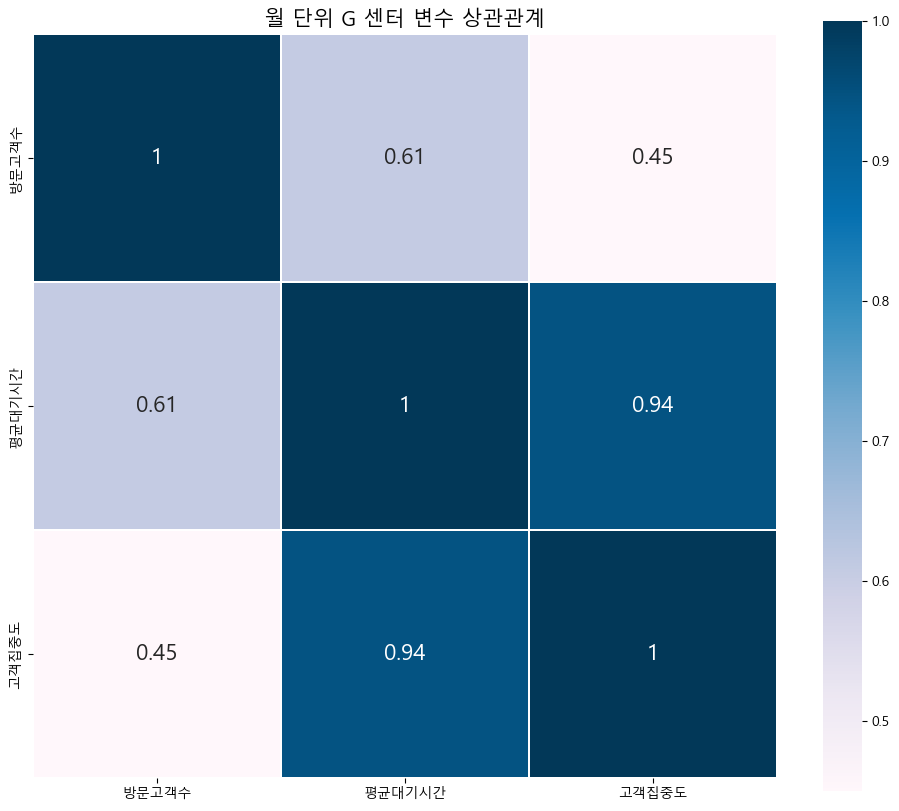

In [1168]:
df_gm = pd.merge(df[0], df[2], on= '센터코드')
df_gm = df_gm[df_gm['센터유형'] == 'G'] # 센터유형 G 만 분류
#df_gm = df_gm[df_gm[('년월일','방문고객수','평균대기시간','고객집중도')]]
df_gm = df_gm.drop(['센터코드','년월일','month','year','센터유형','시도','시군구','행정동'], axis=1)
df_gm = df_gm.groupby(by='년월').mean()

colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("월 단위 G 센터 변수 상관관계", y = 1, size = 15)
sns.heatmap(df_gm.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [970]:
# 행정동 인구수 데이터 결합

df_p = pd.read_csv('주민등록인구.csv')
df_p = df_p.drop(['동별(1)'], axis=1)
df_p.columns = ['시군구', '행정동', '년분기','인구수']

# 인구수 데이터 전처리
df_p.isnull().sum()
df_p.duplicated().sum()

real_dong = list(df[2]['행정동'])
real_dong_rev = []
for i in real_dong:
    if i[-2].isdigit() and i[-3] == '제' and i != '홍제3동':
        dong_rev = i[:-3] + i[-2:]
        real_dong_rev.append(dong_rev)
    else:
        real_dong_rev.append(i)

dp = df_p.loc[:1]
for i in real_dong_rev:
    real_p = df_p[df_p['행정동'] == i]
    dp = pd.concat([dp,real_p])
    
dp = dp.iloc[2:]
dp = dp.reset_index(drop=True)
dp.loc[301] = ['A','B','C','D']
dp.loc[302] = ['A','B','C','D']
dp.loc[303] = ['A','B','C','D']
dp.loc[304] = ['A','B','C','D']
dp.loc[305] = ['A','B','C','D']
dp = dp.shift(5)
dp = dp.iloc[5:]
dp = dp.reset_index(drop=True)

dp_r = pd.merge(df[2], dp, on= ['시군구', '행정동'])
dp_rr = pd.merge(df01, dp_r, on= ['센터코드', '년분기'])

# dp_rr -> 분기별 인구수데이터까지 합체 (sheet1,2,3 + 인구수)

In [971]:
# 구별 소득 데이터 결합

df_m = pd.read_csv('자치구별+1인당+지역내총생산+및+수준지수(2015년+기준)_20221115220808.csv')

real_gu = list(set(list(df[2]['시군구'])))
dm = df_m.loc[:0]
dm = dm.rename(columns=dm.iloc[0])
for i in real_gu:
    real_g = df_m[df_m['자치구별(2)'] == i]
    dm = pd.concat([dm,real_g])

dm = dm.reset_index(drop=True)
dm = dm.drop(['자치구별(1)','1인당 지역내총생산 (천원)'], axis=1)
dm.columns = ['시군구','1인당 소득 (천원)']
dm = dm.astype({'1인당 소득 (천원)':'float64'})

df_all = pd.merge(dp_rr, dm, on= '시군구')

In [980]:
df_all.to_csv("df_all.csv", mode='w')

In [ ]:
# ----------------------------------------------------------------------------- 변수 간 상관계수 확인

In [983]:
# 변수 간 상관계수 확인

Heatmap_data = df_all
Heatmap_data = Heatmap_data.drop(['센터코드','년분기','시도','시군구','행정동'], axis=1)

Heatmap_data.loc[Heatmap_data['센터유형'] == 'G','센터유형'] = 1
Heatmap_data.loc[Heatmap_data['센터유형'] == 'S','센터유형'] = 2

Heatmap_data_G = Heatmap_data[Heatmap_data['센터유형'] == 1] # 센터유형 G 만 분류
Heatmap_data_S = Heatmap_data[Heatmap_data['센터유형'] == 2] # 센터유형 S 만 분류

Heatmap_data_G = Heatmap_data_G.drop('센터유형', axis=1)
Heatmap_data_S = Heatmap_data_S.drop('센터유형', axis=1)

In [984]:
normalization_G = (Heatmap_data_G - Heatmap_data_G.mean())/Heatmap_data_G.std()
normalization_S = (Heatmap_data_S - Heatmap_data_S.mean())/Heatmap_data_G.std()

<AxesSubplot:title={'center':'전체 센터 변수 상관관계'}>

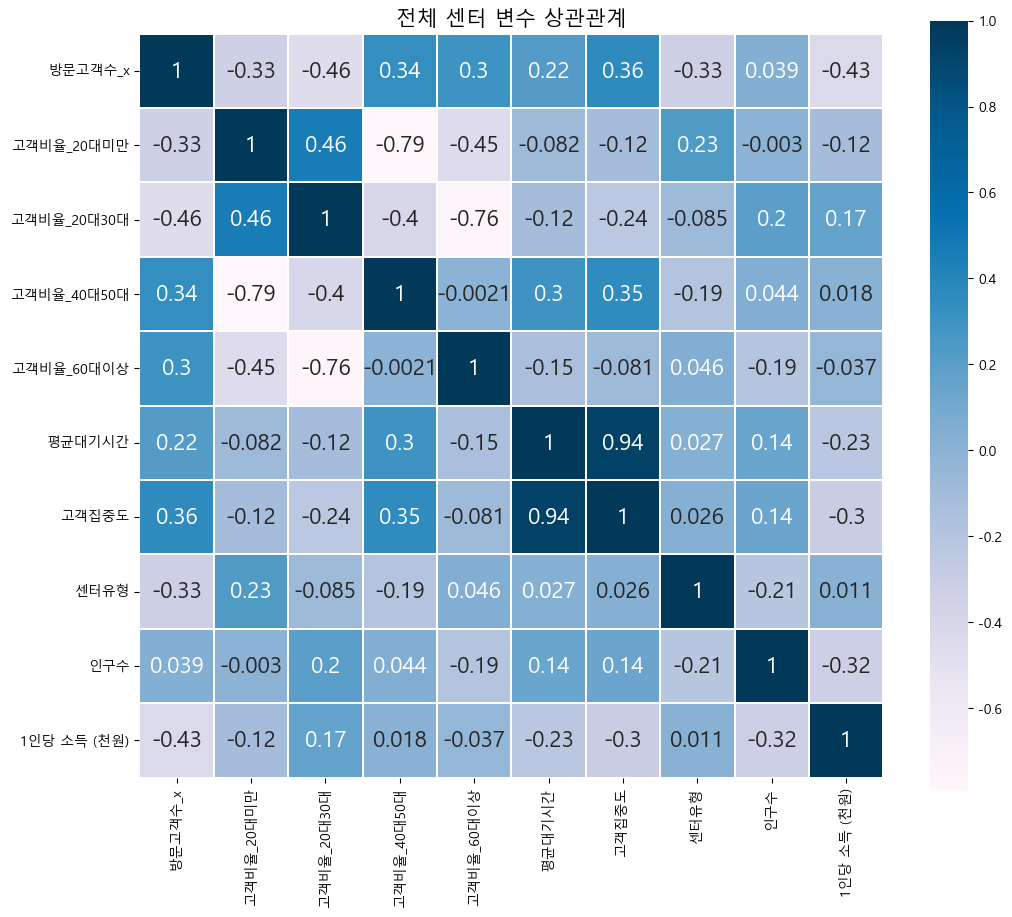

In [988]:
colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("전체 센터 변수 상관관계", y = 1, size = 15)
sns.heatmap(Heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

<AxesSubplot:title={'center':'G 센터 변수 상관관계'}>

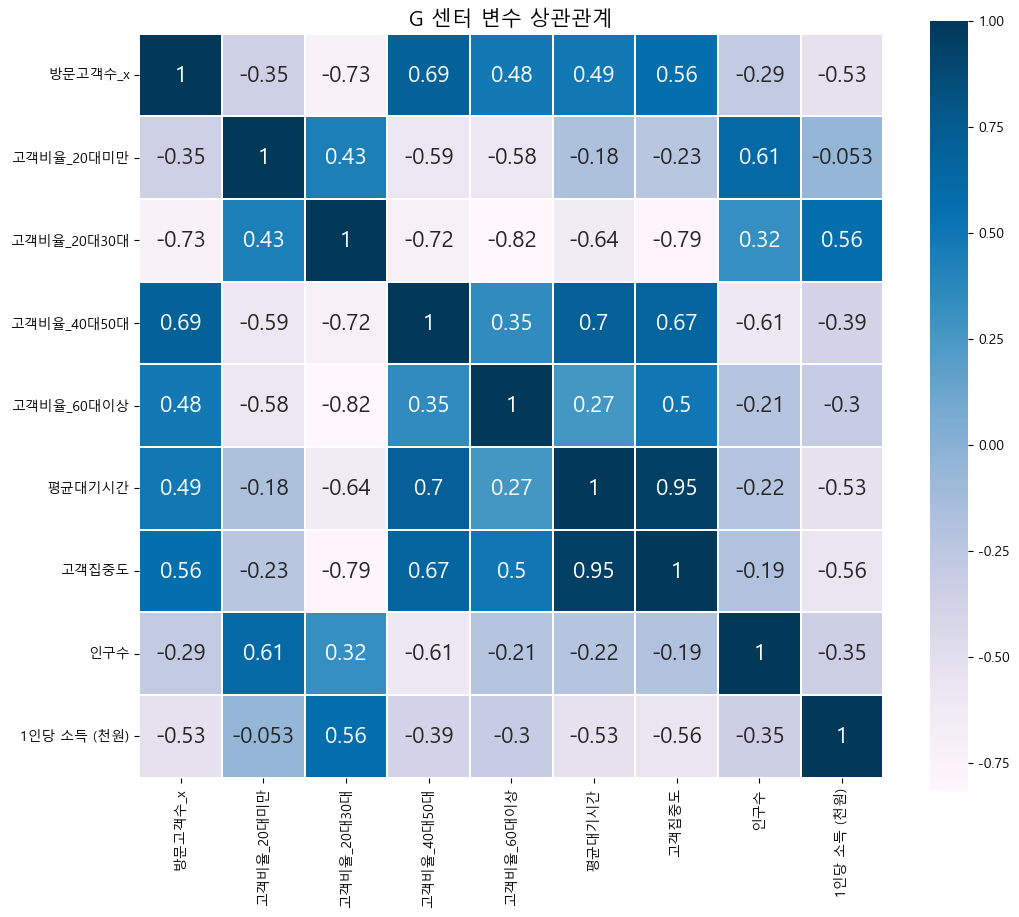

In [989]:
colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("G 센터 변수 상관관계", y = 1, size = 15)
sns.heatmap(normalization_G.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

<AxesSubplot:title={'center':'S 센터 변수 상관관계'}>

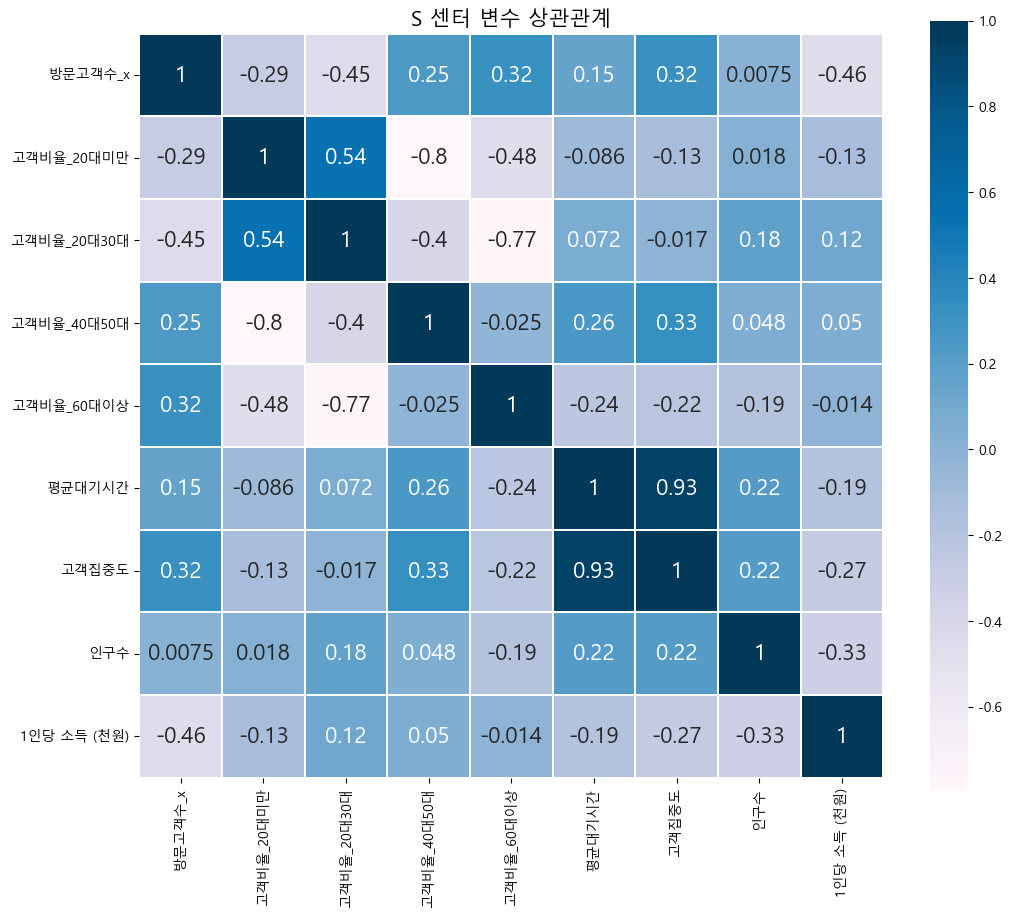

In [990]:
colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("S 센터 변수 상관관계", y = 1, size = 15)
sns.heatmap(normalization_S.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [ ]:
# ----------------------------------------------------------------------------- Raw Data 재분석

In [ ]:
df_new = pd.merge(df[0], df[2], on= ['센터코드'])
df_new = df_new[['센터코드','년월일','방문고객수','평균대기시간','고객집중도','센터유형','시군구','행정동']]

In [996]:
df_new = df_new[['센터코드','년월일','방문고객수','평균대기시간','고객집중도','센터유형','시군구','행정동']]

In [1006]:
df[0]

센터코드        년월일  방문고객수  평균대기시간  고객집중도 month  year         년월
0      0001 2020-01-02    137   44.37      5     1  2020 2020-01-01
1      0001 2020-01-03    144   41.94      5     1  2020 2020-01-01
2      0001 2020-01-06    144   27.96      4     1  2020 2020-01-01
3      0001 2020-01-07    119   33.80      4     1  2020 2020-01-01
4      0001 2020-01-08    130   21.28      4     1  2020 2020-01-01
...     ...        ...    ...     ...    ...   ...   ...        ...
18535  0060 2021-03-25    222   12.47      4     3  2021 2021-03-01
18536  0060 2021-03-26    168   16.13      4     3  2021 2021-03-01
18537  0060 2021-03-29    185   15.34      4     3  2021 2021-03-01
18538  0060 2021-03-30    199   14.23      4     3  2021 2021-03-01
18539  0060 2021-03-31    172   14.98      4     3  2021 2021-03-01

[18540 rows x 8 columns]

In [997]:
df_new

센터코드        년월일  방문고객수  평균대기시간  고객집중도 센터유형  시군구    행정동
0      0001 2020-01-02    137   44.37      5    S  마포구    아현동
1      0001 2020-01-03    144   41.94      5    S  마포구    아현동
2      0001 2020-01-06    144   27.96      4    S  마포구    아현동
3      0001 2020-01-07    119   33.80      4    S  마포구    아현동
4      0001 2020-01-08    130   21.28      4    S  마포구    아현동
...     ...        ...    ...     ...    ...  ...  ...    ...
18535  0060 2021-03-25    222   12.47      4    S  은평구  응암제1동
18536  0060 2021-03-26    168   16.13      4    S  은평구  응암제1동
18537  0060 2021-03-29    185   15.34      4    S  은평구  응암제1동
18538  0060 2021-03-30    199   14.23      4    S  은평구  응암제1동
18539  0060 2021-03-31    172   14.98      4    S  은평구  응암제1동

[18540 rows x 8 columns]

In [999]:
Heatmap_data2 = df_new
Heatmap_data2 = Heatmap_data2.drop(['센터코드','년월일','시군구','행정동'], axis=1)

Heatmap_data2.loc[Heatmap_data2['센터유형'] == 'G','센터유형'] = 1
Heatmap_data2.loc[Heatmap_data2['센터유형'] == 'S','센터유형'] = 2

Heatmap_data2_G = Heatmap_data2[Heatmap_data2['센터유형'] == 1] # 센터유형 G 만 분류
Heatmap_data2_S = Heatmap_data2[Heatmap_data2['센터유형'] == 2] # 센터유형 S 만 분류

Heatmap_data2_G = Heatmap_data2_G.drop('센터유형', axis=1)
Heatmap_data2_S = Heatmap_data2_S.drop('센터유형', axis=1)

<AxesSubplot:title={'center':'일 단위_센터 변수 상관관계'}>

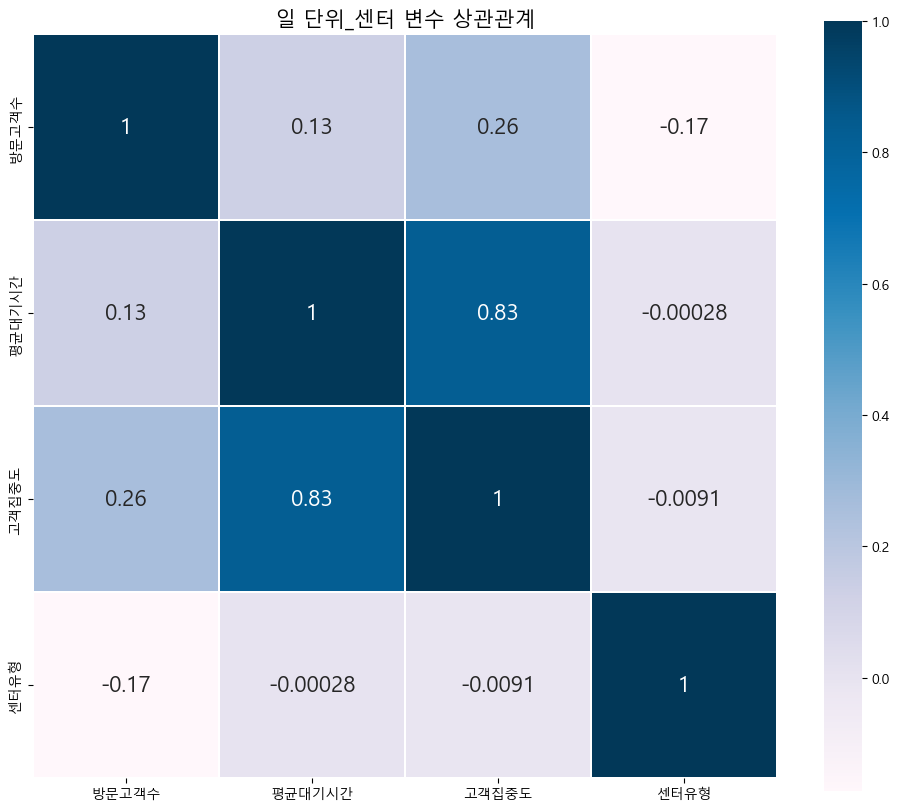

In [1000]:
colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("일 단위_센터 변수 상관관계", y = 1, size = 15)
sns.heatmap(Heatmap_data2.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

<AxesSubplot:title={'center':'일 단위_G 센터 변수 상관관계'}>

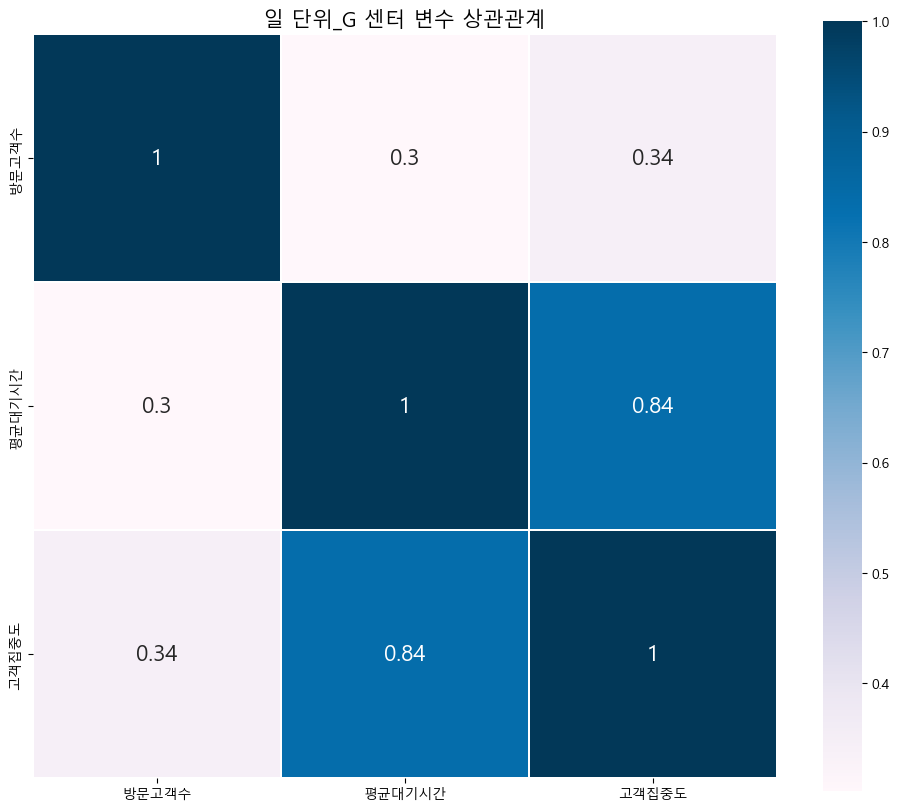

In [1001]:
colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("일 단위_G 센터 변수 상관관계", y = 1, size = 15)
sns.heatmap(Heatmap_data2_G.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

<AxesSubplot:title={'center':'일 단위_S 센터 변수 상관관계'}>

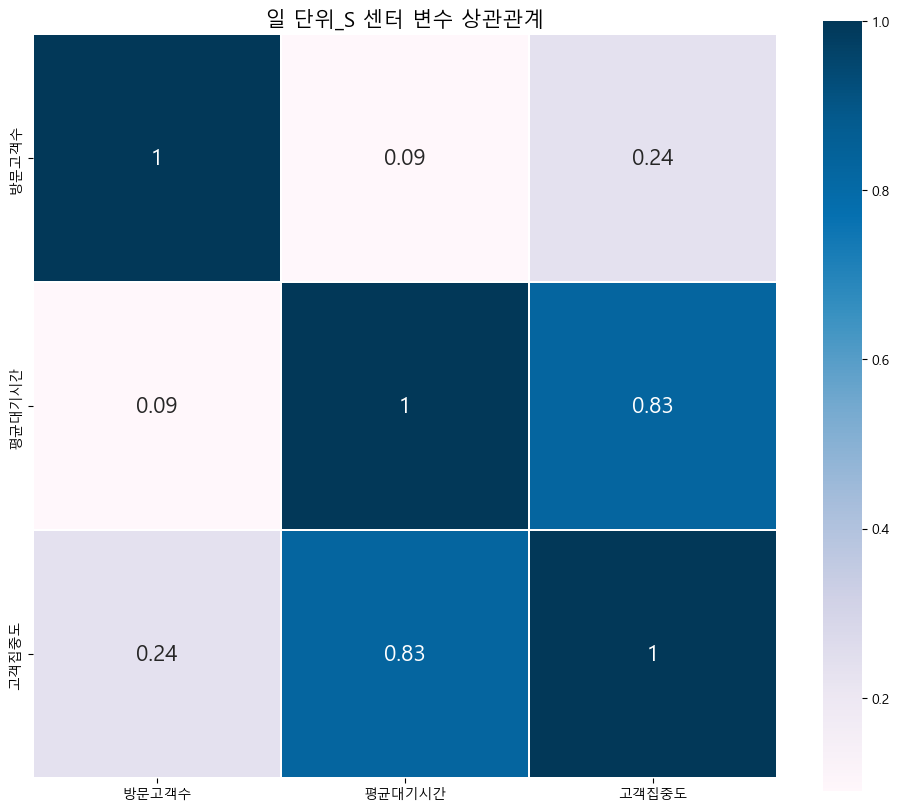

In [1002]:
colormap = plt.cm.PuBu
plt.figure(figsize=(12, 10))
plt.title("일 단위_S 센터 변수 상관관계", y = 1, size = 15)
sns.heatmap(Heatmap_data2_S.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [1005]:
X = Heatmap_data2_G.방문고객수.values
Y1 = Heatmap_data2_G.평균대기시간.values
Y2 = Heatmap_data2_G.고객집중도.values

print('{0} & {1} 상관관계 : {2}' .format('방문고객수','평균대기시간',np.corrcoef(X,Y1)[0,1]))
print('{0} & {1} p-value : {2}' .format('방문고객수','평균대기시간',stats.pearsonr(X,Y1)[1]))
print('{0} & {1} 상관관계 : {2}' .format('방문고객수','고객집중도',np.corrcoef(X,Y2)[0,1]))
print('{0} & {1} p-value : {2}' .format('방문고객수','고객집중도',stats.pearsonr(X,Y2)[1]))

방문고객수 & 평균대기시간 상관관계 : 0.3023831977528959
방문고객수 & 평균대기시간 p-value : 8.350782777230661e-73
방문고객수 & 고객집중도 상관관계 : 0.3439219807035208
방문고객수 & 고객집중도 p-value : 5.510425545391027e-95


In [1071]:
# 센터유형별 서울시 지도 시각화

center_type = df[2][['행정동', '센터유형']]
center_type.columns = ['name', '센터유형']
center_type = center_type.replace({'센터유형' : 'G'}, 5)
center_type = center_type.replace({'센터유형' : 'S'}, 1)
center_type.columns

m2 = folium.Map(
    location = [37.541, 126.986],
    zoom_start = 10.5,
    tiles = 'CartoDB positron'
)

folium.Choropleth(
    geo_data = geo_json2,
    name = 'choropleth',
    data = center_type,
    columns = ['name', '센터유형'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.7
).add_to(m2)

# show
m2
# 노란색 -> G
# 빨간색 -> S

In [ ]:
# ----------------------------------------------------------------------------- 시계열 데이터 분석

In [ ]:
# # 1번 데이터에서 각 para별 상관관계 확인

# X = rev1.방문고객수.values
# Y1 = rev1.평균대기시간.values
# Y2 = rev1.고객집중도.values

# print('{0} & {1} 상관관계 : {2}' .format('방문고객수','평균대기시간',np.corrcoef(X,Y1)[0,1]))
# print('{0} & {1} p-value : {2}' .format('방문고객수','평균대기시간',stats.pearsonr(X,Y1)[1]))
# print('{0} & {1} 상관관계 : {2}' .format('방문고객수','고객집중도',np.corrcoef(X,Y2)[0,1]))
# print('{0} & {1} p-value : {2}' .format('방문고객수','고객집중도',stats.pearsonr(X,Y2)[1]))
# print('{0} & {1} 상관관계 : {2}' .format('평균대기시간','고객집중도',np.corrcoef(Y1,Y2)[0,1]))
# print('{0} & {1} p-value : {2}' .format('평균대기시간','고객집중도',stats.pearsonr(Y1,Y2)[1]))
# plt.subplot(131)
# plt.scatter(X, Y1, color = 'purple', alpha = 0.6)
# plt.title('방문고객수 ~ 평균대기시간')
# plt.xlabel('방문고객수')
# plt.ylabel('평균대기시간')

# plt.subplot(132)
# plt.scatter(X, Y2, color = 'orange', alpha = 0.7)
# plt.title('방문고객수 ~ 고객집중도')
# plt.xlabel('방문고객수')
# plt.ylabel('고객집중도')

# plt.subplot(133)
# plt.scatter(Y1, Y2, color = 'red', alpha = 0.7)
# plt.title('평균대기시간 ~ 고객집중도')
# plt.xlabel('평균대기시간')
# plt.ylabel('고객집중도')
# plt.show()

# # 통계적으로 유의미한 상관관계가 있음을 확인

In [ ]:
# # 1번 데이터에서 각 para별 상관관계 확인

# X = rev1.방문고객수.values
# Y1 = rev1.평균대기시간.values
# Y2 = rev1.고객집중도.values

# print('{0} & {1} 상관관계 : {2}' .format('방문고객수','평균대기시간',np.corrcoef(X,Y1)[0,1]))
# print('{0} & {1} p-value : {2}' .format('방문고객수','평균대기시간',stats.pearsonr(X,Y1)[1]))
# print('{0} & {1} 상관관계 : {2}' .format('방문고객수','고객집중도',np.corrcoef(X,Y2)[0,1]))
# print('{0} & {1} p-value : {2}' .format('방문고객수','고객집중도',stats.pearsonr(X,Y2)[1]))
# print('{0} & {1} 상관관계 : {2}' .format('평균대기시간','고객집중도',np.corrcoef(Y1,Y2)[0,1]))
# print('{0} & {1} p-value : {2}' .format('평균대기시간','고객집중도',stats.pearsonr(Y1,Y2)[1]))
# plt.subplot(131)
# plt.scatter(X, Y1, color = 'purple', alpha = 0.6)
# plt.title('방문고객수 ~ 평균대기시간')
# plt.xlabel('방문고객수')
# plt.ylabel('평균대기시간')

# plt.subplot(132)
# plt.scatter(X, Y2, color = 'orange', alpha = 0.7)
# plt.title('방문고객수 ~ 고객집중도')
# plt.xlabel('방문고객수')
# plt.ylabel('고객집중도')

# plt.subplot(133)
# plt.scatter(Y1, Y2, color = 'red', alpha = 0.7)
# plt.title('평균대기시간 ~ 고객집중도')
# plt.xlabel('평균대기시간')
# plt.ylabel('고객집중도')
# plt.show()

# # 통계적으로 유의미한 상관관계가 있음을 확인

In [ ]:
# 1. 시계열 분석

In [1008]:
df_g = df_new
df_g = df_g.drop(['센터코드','시군구','행정동'], axis=1)
df_g.loc[df_g['센터유형'] == 'G','센터유형'] = 1
df_g = df_g[Heatmap_data2['센터유형'] == 1] # 센터유형 G 만 분류

In [1021]:
# 방문고객수 시계열 데이터 전처리
tmp = df_g.groupby(by='년월일').sum()
tmp = tmp[['방문고객수']]
a = list(df[0]['년월일'].tolist())
b = list(tmp['방문고객수'].tolist())
ts = pd.DataFrame(zip(a,b))
ts.columns = ['년월일', '방문고객수']

In [1022]:
# 이상치 제거
quartile_1 = ts.quantile(0.25)
quartile_3 = ts.quantile(0.75)
IQR = quartile_3 - quartile_1

ts = ts[ts.방문고객수 > float(quartile_1) - float(IQR)*1.5]
ts = ts[ts.방문고객수 < float(quartile_3) + float(IQR)*1.5]
c = list(ts['년월일'].tolist())

dou = []
for i in a:
    if i not in c:
        dou.append(i)

tmp = tmp.drop(['2020-09-28 00:00:00', '2020-05-25 00:00:00'])

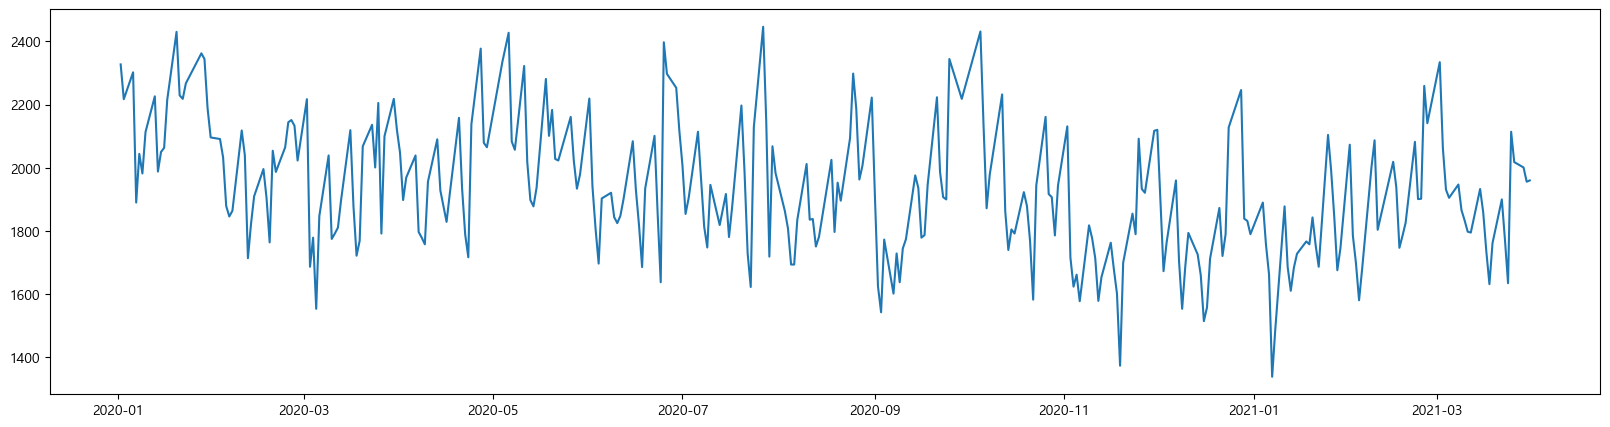

In [1023]:
plt.figure(figsize=(20,5))
plt.plot(tmp['방문고객수'])
plt.show()

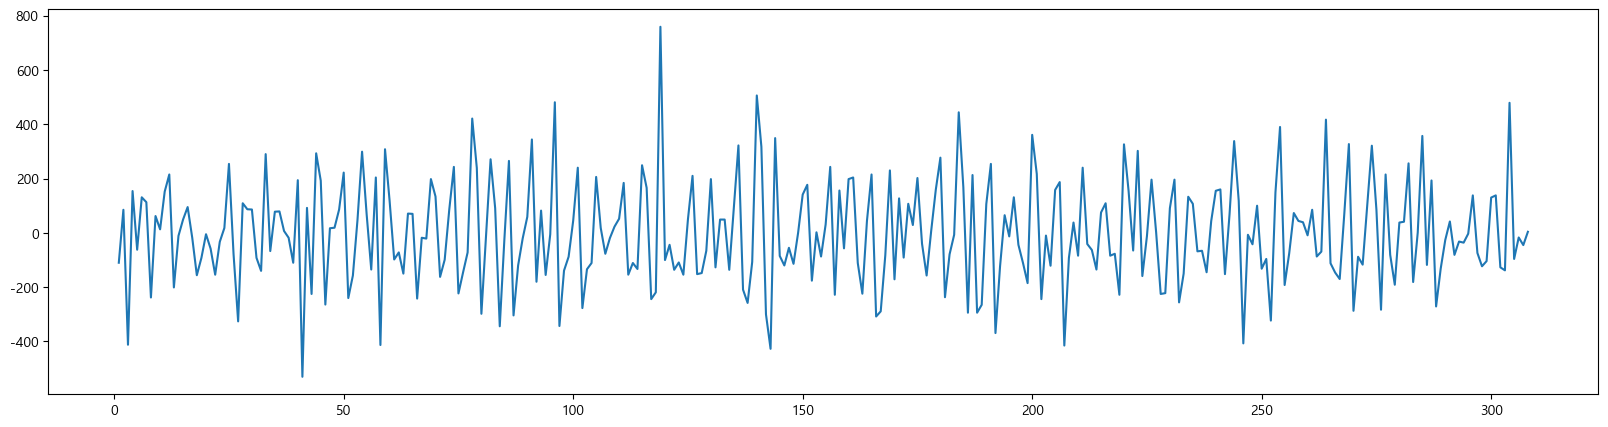

In [1024]:
# 1차 차분
ts_diff = ts - ts.shift()
plt.figure(figsize=(20,5))
plt.rcParams['axes.unicode_minus'] = False
plt.plot(ts_diff['방문고객수'])
plt.show()

In [1025]:
tmp_train = tmp.iloc[:-60] # 8:2 Train / Test Data 나누기
tmp_diff_train = tmp - tmp.shift() # 1차 차분
tmp_diff_train = tmp_diff_train.dropna(axis=0)
tmp_diff_train

방문고객수
년월일              
2020-01-03 -110.0
2020-01-06   85.0
2020-01-07 -412.0
2020-01-08  154.0
2020-01-09  -62.0
...           ...
2021-03-25  479.0
2021-03-26  -96.0
2021-03-29  -17.0
2021-03-30  -45.0
2021-03-31    4.0

[306 rows x 1 columns]

In [1026]:
ts_diff_train = ts_diff.iloc[:-60]
ts_diff_train = ts_diff_train[1:]
ts_diff_train

년월일  방문고객수
1   1 days -110.0
2   3 days   85.0
3   1 days -412.0
4   1 days  154.0
5   1 days  -62.0
..     ...    ...
244 1 days  338.0
245 4 days  118.0
246 1 days -407.0
247 1 days   -7.0
248 1 days  -42.0

[248 rows x 2 columns]

In [1027]:
ts_train = ts.iloc[:-60]

In [ ]:
# 정상성 확인 관련 ACF / p-value 확인

C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


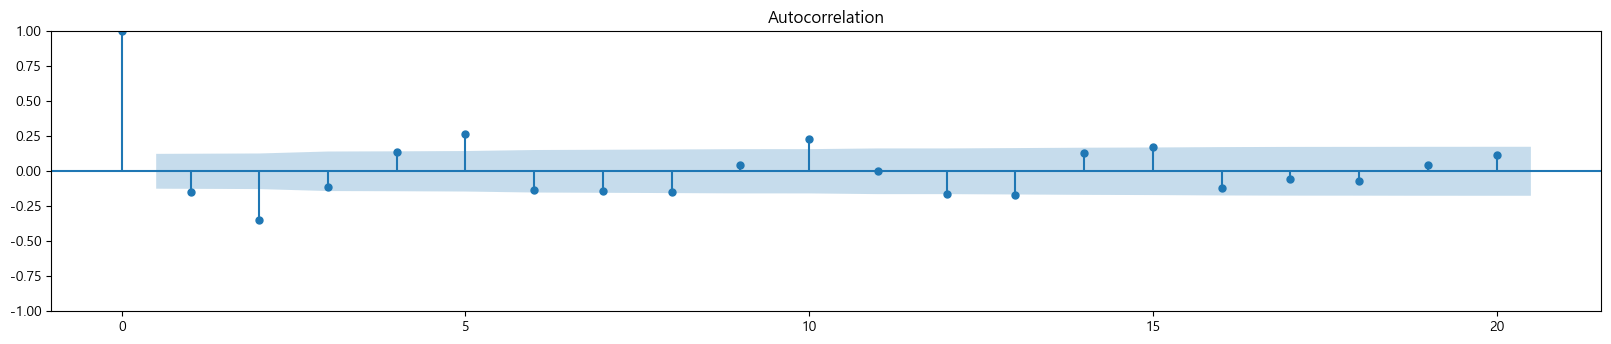

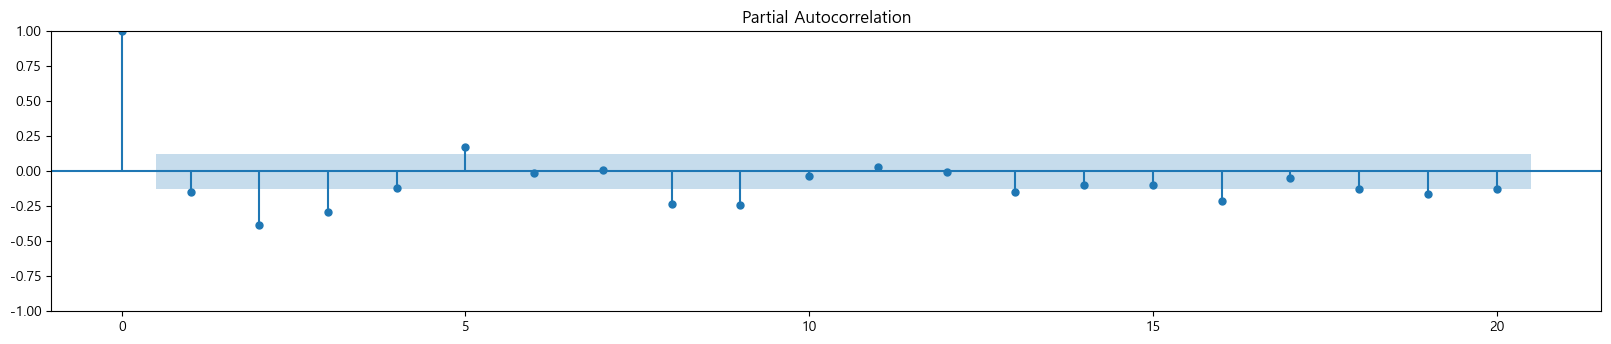

In [1028]:
# ACF 확인 - 빠르게 값이 작아짐
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff_train['방문고객수'], lags=20, ax=ax1)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff_train['방문고객수'], lags=20, ax=ax1)

# q, p 모두 금방 0에 수렴하기에 ARIMA(2,1,2) 모형을 BASE 로 몇 가지 모델을 시도해볼 수 있다.

In [1029]:
# p-value : 0.5 이하로 귀무가설 기각 가능
from statsmodels.tsa.stattools import adfuller
result = adfuller(tmp_diff_train)
print('ADF Statistic : %f' % result[0])
print('p-value : %f' % result[1])

ADF Statistic : -8.204719
p-value : 0.000000


In [1030]:
import itertools
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = range(0,4)
d = range(1,2)
q = range(0,5)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = SARIMAX(ts_diff_train['방문고객수'], order=(i))
            model_fit = model.fit()
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 10%|████████▎                                                                          | 2/20 [00:00<00:01, 17.88it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  4.36it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:01,  3.90it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.p

In [1031]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(ts_diff_train['방문고객수'], order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

#탐색된 파라미터들 중 aic가 가장 낮은 모델을 최적의 모델로 선택
#최적의 파라미터는 (2,1,4)

C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  방문고객수   No. Observations:                  248
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1612.360
Date:                Wed, 16 Nov 2022   AIC                           3238.719
Time:                        00:15:33   BIC                           3263.285
Sample:                             0   HQIC                          3248.609
                                - 248                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5889      0.050     11.712      0.000       0.490       0.687
ar.L2         -0.8914      0.049    -18.045      0.000      -0.988      -0.795
ma.L1         -1.9664      4.887     -0.402      0.687     -11.544       7.611
ma.L2          1.8704      4.710      0.397      0.691      -7.360      11.101
ma.L3         -1.0668      4.386     -0.243      0.808      -9.664       7.530
ma.L4          0.1629      0.771      0.211      0.833      -1.349       1.675
sigma2      2.654e+04    1.3e+05      0.204      0.838   -2.28e+05    2.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 9.66
Prob(Q):                              0.89   Prob(JB):                         0.01
Heteroskedasticity (H):               1.10   Skew:                             0.18
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

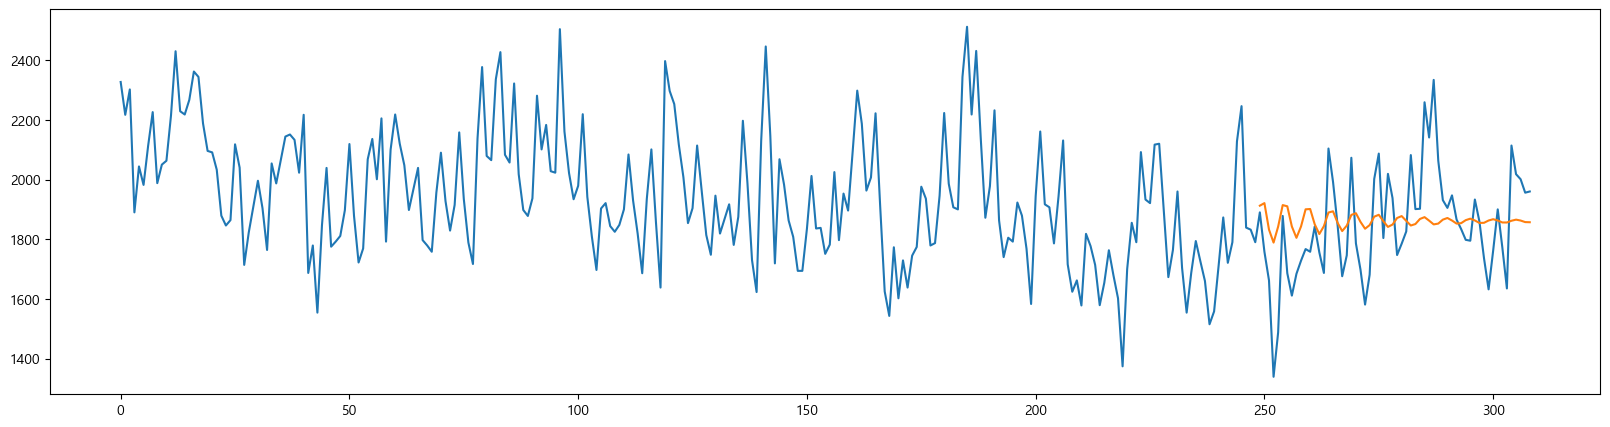

In [1035]:
model = ARIMA(ts_train['방문고객수'], order=optimal[0][0])
model_fit = model.fit()
forecast = model_fit.forecast(steps=60)

plt.figure(figsize=(20,5))
plt.plot(range(0,309), ts['방문고객수'].iloc[0:])
plt.plot(forecast)

# 결과를 확인해보면 처음 step들은 비슷하지만 바로 전혀 예측을 제대로 하지 못하는 것을 확인 할 수 있다.

In [1053]:
# SARIMAX: 24
# ARIMA에서 데이터의 주기성을 추가로 고려해 주는 SARIMAX를 이용하여 학습을 진행

p = range(0,4)
d = range(1,2)
q = range(0,5)
m = 100
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1], x[2], m) for x in list(itertools.product(p,d,q))]

aic = []
params = []

with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(ts_train['방문고객수'], order=(i), season_order = (j))
                model_fit = model.fit()
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue

 30%|████████████████████████▏                                                       | 121/400 [00:11<00:11, 24.89it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 31%|████████████████████████▊                                                       | 124/400 [00:12<00:19, 14.09it/s]C:\Use

 91%|████████████████████████████████████████████████████████████████████████▌       | 363/400 [01:09<00:15,  2.43it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 91%|████████████████████████████████████████████████████████████████████████▊       | 364/400 [01:09<00:16,  2.23it/

C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 93%|██████████████████████████████████████████████████████████████████████████▌     | 373/400 [01:15<00:16,  1.65it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maxim

 96%|████████████████████████████████████████████████████████████████████████████▊   | 384/400 [01:21<00:08,  1.78it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 96%|█████████████████████████████████████████████████████████████████████████████   | 385/400 [01:22<00:09,  1.58it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 96%|█████████████████████████████████████████████████████████████████████████████▏  | 386/400 [01:23<00:09,  1.48it/s]C:\Users\pozz3\AppData\Roaming\Python\Python38\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

In [1055]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = SARIMAX(ts_train['방문고객수'], order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

# 가장 낮은 aic를 기준으로 찾은 최적의 모델의 결과는 위와 같다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                방문고객수   No. Observations:                  249
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 100)   Log Likelihood               -1011.896
Date:                              Wed, 16 Nov 2022   AIC                           2035.791
Time:                                      00:35:03   BIC                           2053.775
Sample:                                           0   HQIC                          2043.098
                                              - 249                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4128      0.248     -1.662      0.096      -0.900       0.074
ar.L2          0.4473      0.179      2.495      0.013       0.096       0.799
ma.L1         -0.1138      1.489     -0.076      0.939      -3.033       2.805
ma.L2         -0.9764      1.256     -0.777      0.437      -3.438       1.485
ma.L3          0.0908      0.294      0.309      0.757      -0.485       0.667
sigma2      4.936e+04   6.75e+04      0.731      0.465    -8.3e+04    1.82e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                59.49
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.14
Prob(H) (two-sided):                  0.51   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

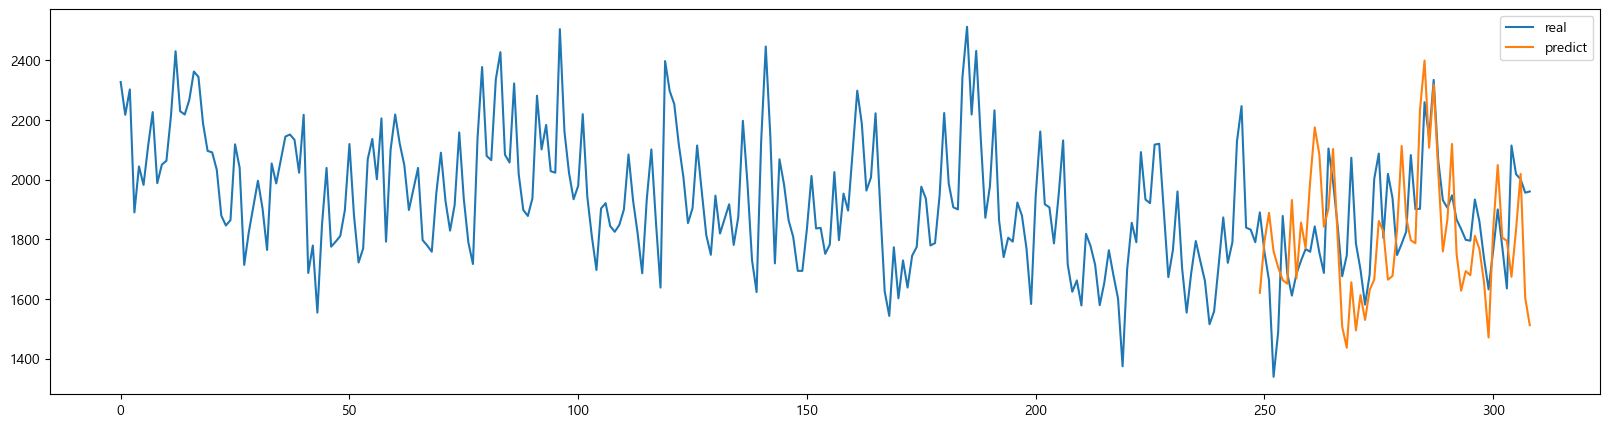

In [1056]:
model = SARIMAX(ts_train['방문고객수'], order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=60)

plt.figure(figsize=(20,5))
plt.plot(range(0,309), ts['방문고객수'].iloc[0:], label="real")
plt.plot(forecast, label="predict")
plt.legend()
plt.show()

In [1170]:
# 시계열 모델 평가
from sklearn import metrics

def RMSE(y_pred, y_true):
    return metrics.mean_absolute_percentage_error(y_true,y_pred)*100

def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def Rsquare()

print("RMSE :", RMSE(forecast, ts['방문고객수'].iloc[-60:]))
print("MAPE :", MAPEval(forecast, ts['방문고객수'].iloc[-60:]))

# RMSE : MSE는 SSE를 자유도로 나누어준 값이다. 자유도를 나누어 줌으로써 MSE가 크다의 의미는 단순히 데이터가 많아서 크다는 것이
# 아니라(SSE는 데이터 수가 많아지면 커진다.) 실제 차이가 커서 크다고 판단할 수 있게 되는 것이다.

# MAPE : MAPE는 MAE에서 실제 관측값과 회귀식으로 예측한 값 차이를 회귀식으로 예측한 값으로 나눈 절대값의 합이다.
# MAE는 outlier에 취약할 수 있는데(한 없이 커질 수 있다는 의미이다.)
# MAPE는 최대 크기가 제한되므로 이를 보완한 개념이라고 볼 수 있다.

RMSE : 9.55638409981098
MAPE : 9.556384099810979


In [ ]:
# ----------------------------------------------------------------------------- 다중 선형 회귀 분석

In [ ]:
# 다중 선형 회귀를 위한 데이터 결합

In [1441]:
df_mul = rev2
df_1r = df[1].drop('방문고객수', axis=1)
df_mul = pd.merge(df_mul, df_1r, on =['센터코드','년월'])
df_mul = pd.merge(df_mul, df[2], on = '센터코드')

In [1442]:
df_ymd = df[3].astype({'년월일':'str'})
df_ymd['년월일']=df_ymd['년월일'].apply(lambda _ : datetime.strptime(_,'%Y-%m-%d'))
df_ymd['month'] = df_ymd['년월일'].dt.month
df_ymd['year'] = df_ymd['년월일'].dt.year
df_ymd = df_ymd.astype({'month':'str'})
df_ymd = df_ymd.astype({'year':'str'})
df_ymd["년월"] = df_ymd["year"] + "-" + df_ymd["month"]
df_ymd = df_ymd.drop(['month','year'], axis=1)
df_ymd = pd.merge(df_ymd, aa, on= '년월')
df_ymd = df_ymd.drop(['년월일','휴일여부'], axis=1)
df_ymd = df_ymd.astype({'년월':'datetime64[ns]'})

In [1443]:
df_mul = pd.merge(df_mul, df_ymd, on= '년월')
df_mul = df_mul.drop(['시도','시군구','행정동'], axis=1)
df_mul = df_mul.drop_duplicates()
df_mul = df_mul.reset_index(drop=True)
df_mul = df_mul.drop(['센터코드','년월'], axis=1)
df_mul = df_mul[df_mul['센터유형'] == 'G'] # 센터유형 G 만 분류
df_mul = df_mul.drop('센터유형', axis=1)
df_mul = df_mul.reset_index(drop=True)

In [1457]:
# 최종 결합 DataFrame
df_mul

방문고객수     평균대기시간     고객집중도  고객비율_20대미만  고객비율_20대30대  고객비율_40대50대  \
0    232.000000  23.932000  4.300000    0.091185     0.209119     0.444985   
1    234.100000  36.528500  4.800000    0.092224     0.203737     0.498493   
2    206.200000  17.829500  3.850000    0.122512     0.300373     0.430348   
3    224.700000  21.503500  3.850000    0.079781     0.202801     0.481121   
4    132.800000  15.025500  3.450000    0.059150     0.189156     0.497227   
..          ...        ...       ...         ...          ...          ...   
160  110.863636   6.753636  2.500000    0.111600     0.332051     0.390324   
161  220.590909  21.820455  4.090909    0.087907     0.164126     0.426829   
162  126.045455  13.585909  3.363636    0.100213     0.247335     0.427505   
163  184.772727  16.852273  3.727273    0.141195     0.194077     0.452142   
164  171.863636   8.890455  2.954545    0.113791     0.202937     0.455690   

     고객비율_60대이상  월별 휴일 수  
0      0.254711       11  
1      0.205546       11  
2      0.146766       11  
3      0.236297       11  
4      0.254467       11  
..          ...      ...  
160    0.166025        9  
161    0.321138        9  
162    0.224947        9  
163    0.212586        9  
164    0.227583        9  

[165 rows x 8 columns]

In [ ]:
# 다중선형회귀 데이터 분리

In [1445]:
x_data = df_mul.drop(['평균대기시간'],axis=1)   # Feature에서 Target Data 분리
target = df_mul[['평균대기시간']] # Target 변수저장

x_data.head()

방문고객수  고객집중도  고객비율_20대미만  고객비율_20대30대  고객비율_40대50대  고객비율_60대이상  월별 휴일 수
0  232.0   4.30    0.091185     0.209119     0.444985    0.254711       11
1  234.1   4.80    0.092224     0.203737     0.498493    0.205546       11
2  206.2   3.85    0.122512     0.300373     0.430348    0.146766       11
3  224.7   3.85    0.079781     0.202801     0.481121    0.236297       11
4  132.8   3.45    0.059150     0.189156     0.497227    0.254467       11

In [1446]:
# 회귀분석을 하기 위한 B_0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# 회귀모델 적합
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()

# summary함수를 통해 OLS 결과 출력
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 평균대기시간   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     149.6
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           4.28e-66
Time:                        17:54:41   Log-Likelihood:                -405.87
No. Observations:                 165   AIC:                             827.7
Df Residuals:                     157   BIC:                             852.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.335e+08   4.28e+08     -1.014      0.312   -1.28e+09    4.11e+08
방문고객수          -0.0012      0.006     -0.215      0.830      -0.013       0.010
고객집중도          11.8116      0.475     24.886      0.000      10.874      12.749
고객비율_20대미만   4.335e+08   4.28e+08      1.014      0.312   -4.11e+08    1.28e+09
고객비율_20대30대  4.335e+08   4.28e+08      1.014      0.312   -4.11e+08    1.28e+09
고객비율_40대50대  4.335e+08   4.28e+08      1.014      0.312   -4.11e+08    1.28e+09
고객비율_60대이상   4.335e+08   4.28e+08      1.014      0.312   -4.11e+08    1.28e+09
월별 휴일 수         0.3020      0.182      1.655      0.100      -0.058       0.662
==============================================================================
Omnibus:                       18.142   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.930
Skew:                           0.725   Prob(JB):                     1.73e-05
Kurtosis:                       4.044   Cond. No.                     7.67e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.21e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1447]:
fitted_multi_model.params

const         -4.335261e+08
방문고객수         -1.243526e-03
고객집중도          1.181162e+01
고객비율_20대미만     4.335261e+08
고객비율_20대30대    4.335261e+08
고객비율_40대50대    4.335261e+08
고객비율_60대이상     4.335261e+08
월별 휴일 수        3.020073e-01
dtype: float64

In [ ]:
#[2] The smallest eigenvalue is 5.44e-17. This might indicate that there are 
# strong multicollinearity problems or that the design matrix is singular.

# → 다중공선성이 있음을 암시한다.

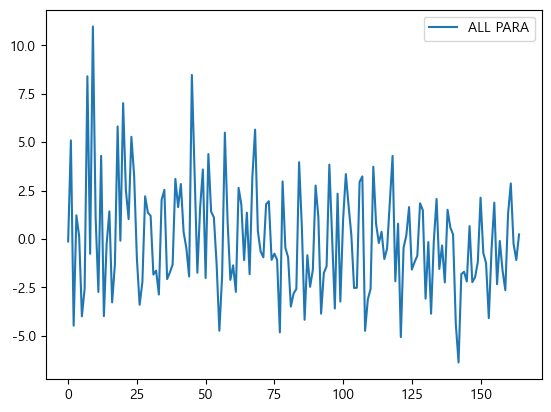

In [1448]:
# y_hat 구하기

pred4 = fitted_multi_model.predict(x_data1)

# residual plot 구하기
fitted_multi_model.resid.plot(label = "ALL PARA")
plt.legend()

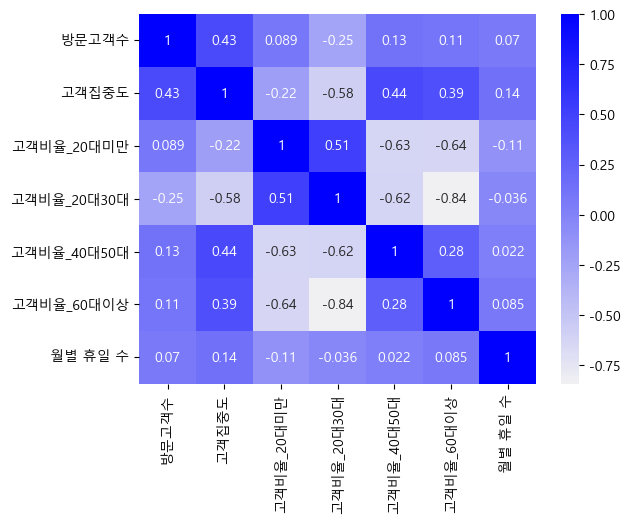

In [1454]:
import seaborn as sns                        #heatmap 만들기 위한 라이브러리
cmap = sns.light_palette("Blue", as_cmap = True)  
sns.heatmap(x_data.corr(), annot = True, cmap = cmap)
plt.show()

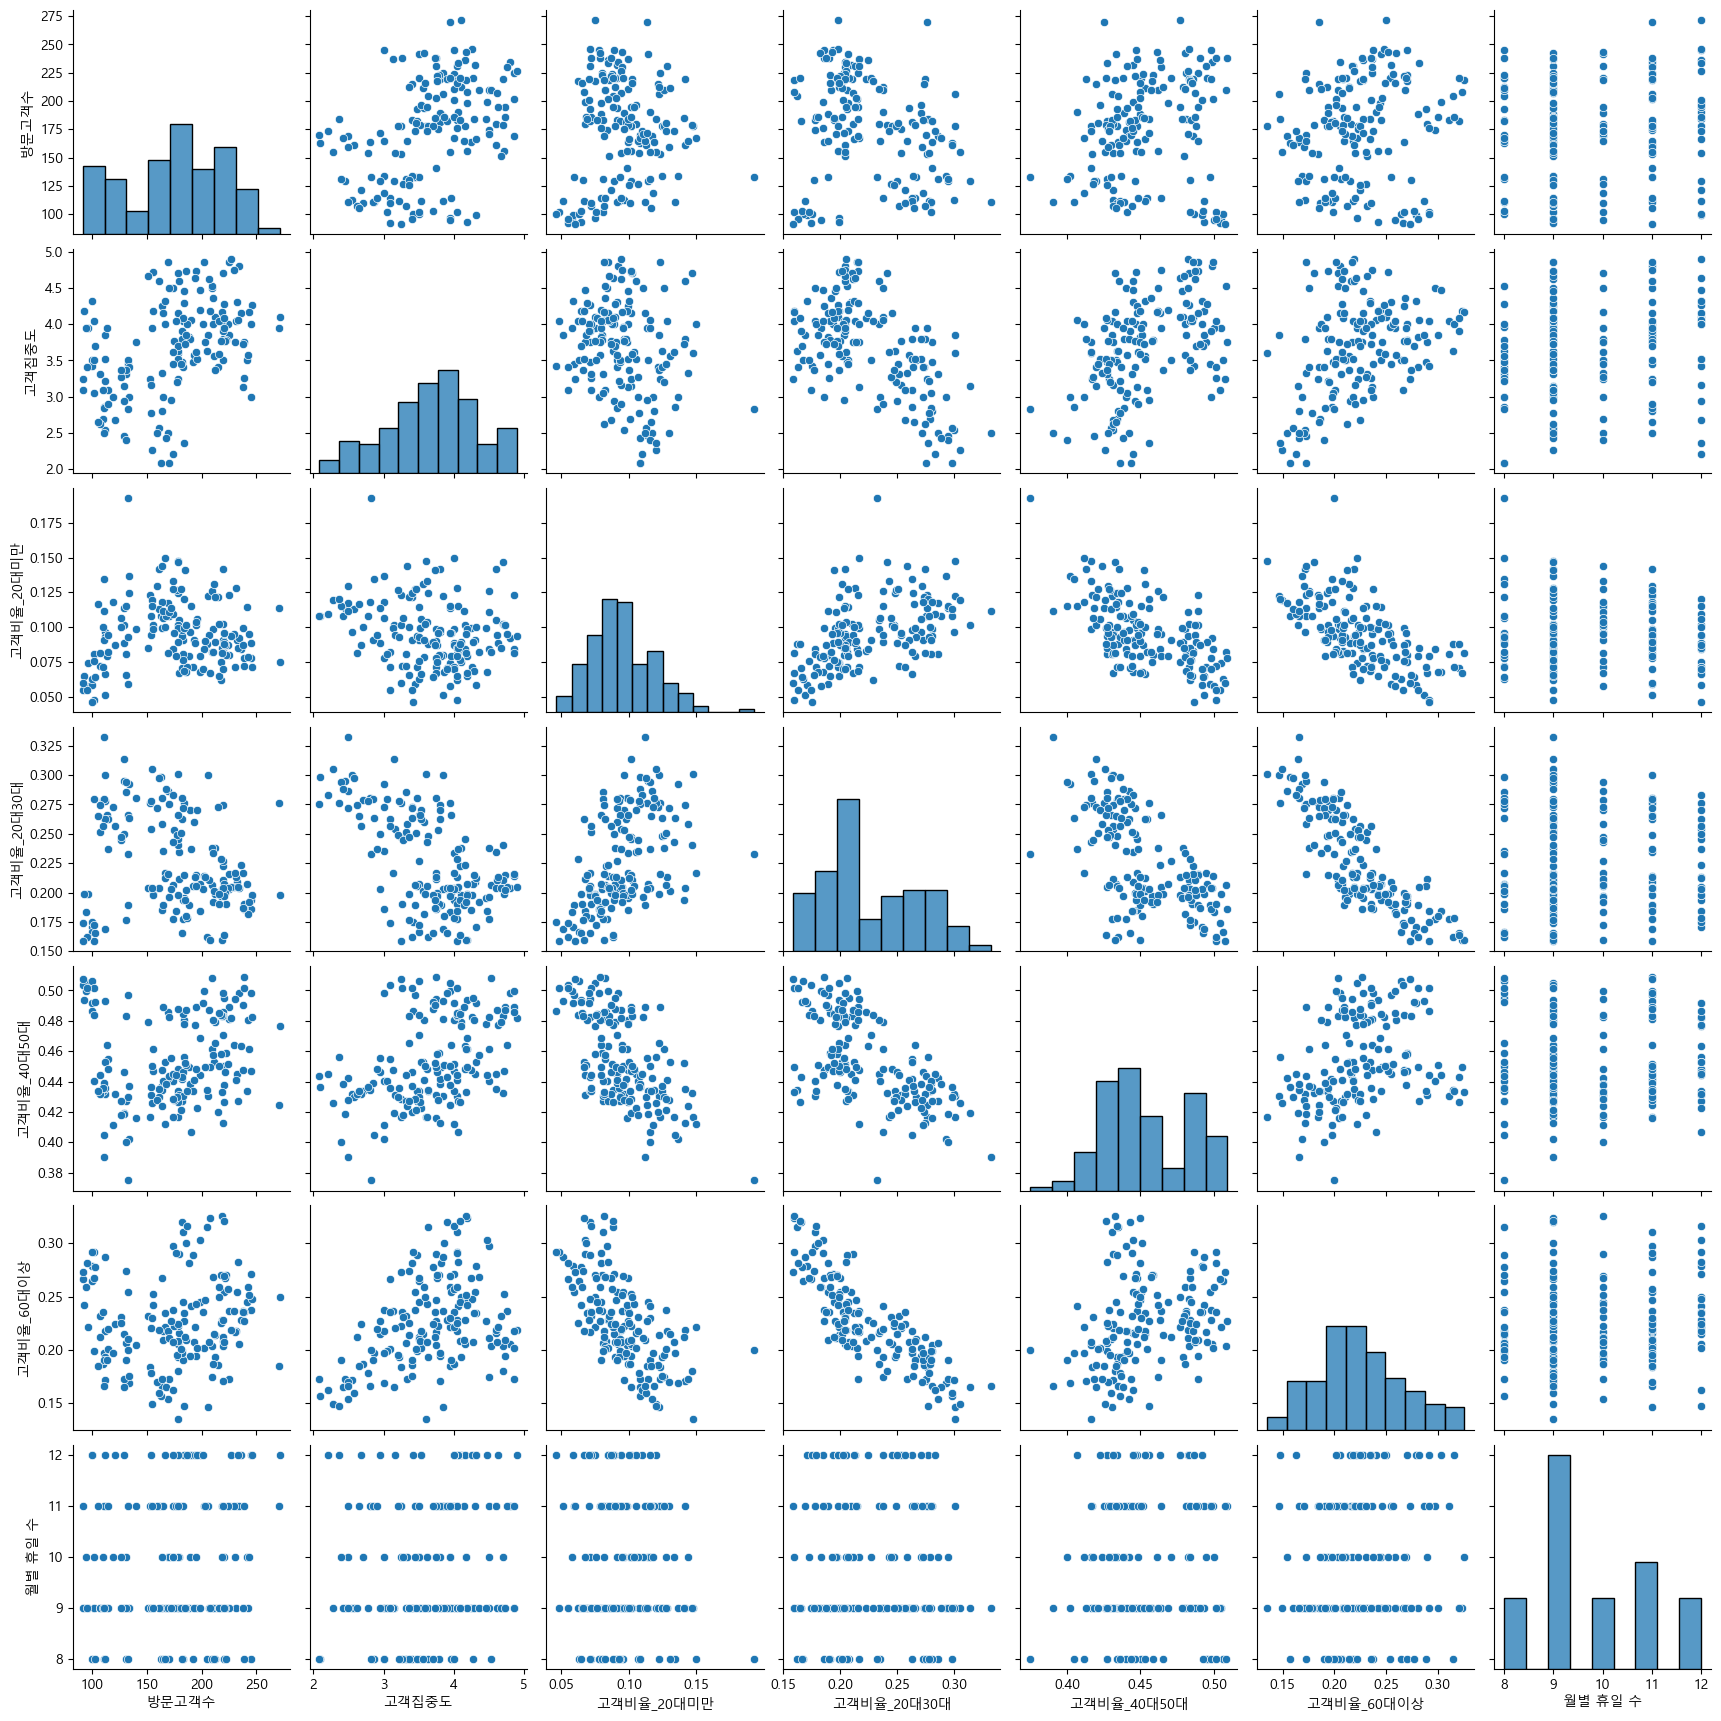

In [1450]:
sns.pairplot(x_data)
plt.show()

In [1463]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF사용을 위한 라이브러리, statsmodels안에 존재한다.
# 사실 모든 통계기법이 statsmodels 모듈에 존재하여 
# 이 중에 필요한 통계기법을 찾아 import를 진행하면 된다.

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_data.values, i) for i in range(x_data.shape[1])]
vif["features"] = x_data.columns
vif

VIF Factor     features
0   21.326881        방문고객수
1   61.190269        고객집중도
2   26.739260   고객비율_20대미만
3   57.944123  고객비율_20대30대
4  159.510016  고객비율_40대50대
5   50.039244   고객비율_60대이상
6   63.244830      월별 휴일 수

In [ ]:
# VIF 값이 큰 para 가 많으므로 순차적으로 제거 예정

In [1464]:
# '고객비율_40대50대' 변수 제거 후 vif 확인

vif = pd.DataFrame()
x_data2 = x_data.drop('고객비율_40대50대',axis=1)
vif["VIF Factor"] = [variance_inflation_factor(x_data2.values, i) for i in range(x_data2.shape[1])]
vif["features"] = x_data2.columns
vif

VIF Factor     features
0   21.200664        방문고객수
1   47.389108        고객집중도
2   26.320648   고객비율_20대미만
3   39.089254  고객비율_20대30대
4   35.223010   고객비율_60대이상
5   61.936410      월별 휴일 수

In [1470]:
# '월별 휴일 수, 고객집중도' 변수 제거후 VIF확인

vif = pd.DataFrame()
x_data3 = x_data2.drop(['월별 휴일 수', '고객집중도'],axis = 1)
vif["VIF Factor"] = [variance_inflation_factor(x_data3.values, i) for i in range(x_data3.shape[1])]
vif["features"] = x_data3.columns
vif

VIF Factor     features
0   17.042465        방문고객수
1   25.583110   고객비율_20대미만
2   27.262964  고객비율_20대30대
3   14.738368   고객비율_60대이상

In [1471]:
# '고객비율_20대30대' 변수 제거후 VIF확인

vif = pd.DataFrame()
x_data4 = x_data3.drop('고객비율_20대30대',axis = 1)
vif["VIF Factor"] = [variance_inflation_factor(x_data4.values, i) for i in range(x_data4.shape[1])]
vif["features"] = x_data4.columns
vif

VIF Factor    features
0   17.021625       방문고객수
1   10.028134  고객비율_20대미만
2   12.792452  고객비율_60대이상

In [1472]:
# 변수 제거한 x_data4 상수항 추가 후 회귀모델 적합시키기

x_data4_ = sm.add_constant(x_data4, has_constant = "add")

model_vif2 = sm.OLS(target,x_data4_)
fitted_model_vif = model_vif2.fit()


#변수제거 회귀모델의 결과를 비교
fitted_model_vif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 평균대기시간   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     13.10
Date:                Wed, 16 Nov 2022   Prob (F-statistic):           1.07e-07
Time:                        18:03:42   Log-Likelihood:                -555.93
No. Observations:                 165   AIC:                             1120.
Df Residuals:                     161   BIC:                             1132.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6740      6.254      0.428      0.670      -9.677      15.025
방문고객수          0.0679      0.013      5.329      0.000       0.043       0.093
고객비율_20대미만   -28.8605     31.074     -0.929      0.354     -90.226      32.505
고객비율_60대이상    26.0180     17.784      1.463      0.145      -9.103      61.139
==============================================================================
Omnibus:                       29.046   Durbin-Watson:                   2.279
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.003
Skew:                           1.122   Prob(JB):                     5.59e-09
Kurtosis:                       3.703   Cond. No.                     1.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

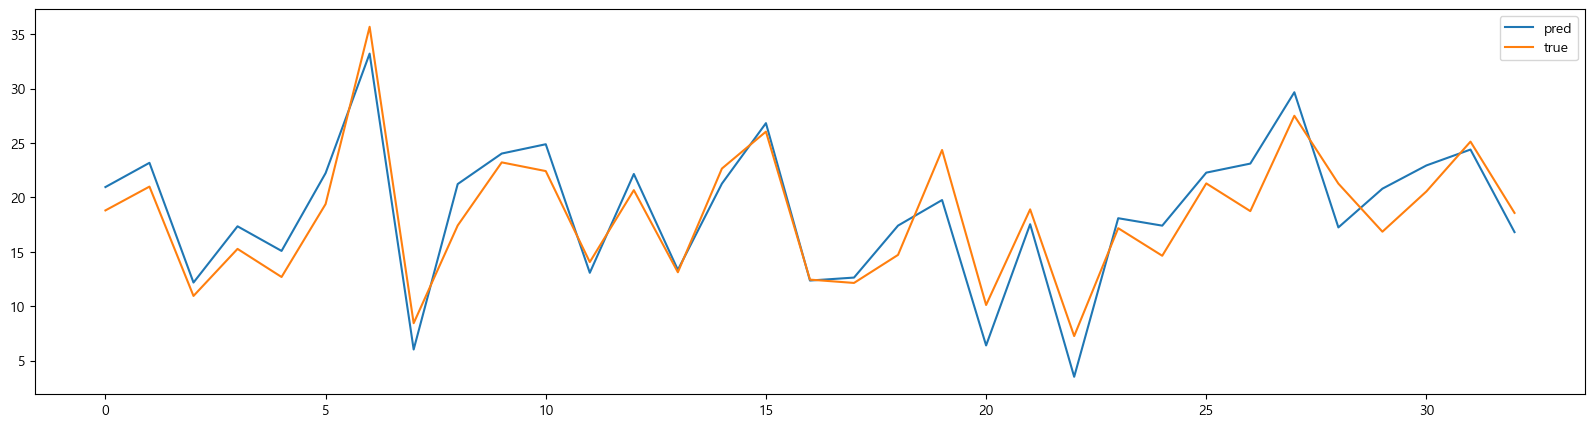

In [1478]:
# train_x에 상수항 추가 후 최귀모델 적합

fit_train1 = sm.OLS(train_y,train_x)
fit_train1 = fit_train1.fit()

# 검증데이터에 대한 예측값과 true값 비교
plt.figure(figsize=(20,5))
plt.plot(np.array(fit_train1.predict(test_x)),label = "pred")
plt.plot(np.array(test_y),label = "true")
plt.legend()
plt.show()

In [1474]:
# 학습 검증데이터 분할
from sklearn.model_selection import train_test_split
# 변수 제거 전 모델
X = x_data
y = target

train_x, test_x, train_y, test_y = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 1)
# 학습데이터와 검증데이터를 8:2으로 분리한다.
# random_state고정을 통해 그때마다 똑같은 값을 분류하도록 한다.


# 변수 제거 후 모델
X = x_data4
y = target

train_x2, test_x2, train_y2, test_y2 = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 1)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)
print(train_x2.shape, test_x2.shape, train_y2.shape, test_y2.shape)

(132, 7) (33, 7) (132, 1) (33, 1)
(132, 3) (33, 3) (132, 1) (33, 1)


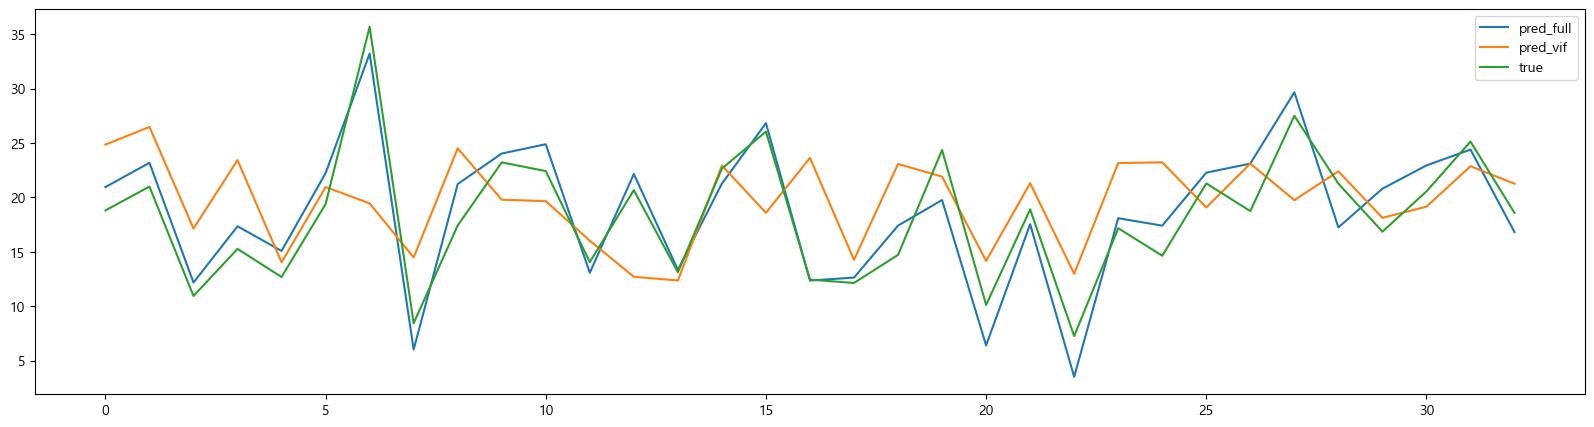

In [1475]:
# train_x에 상수항 추가 후 최귀모델 적합

fit_train1 = sm.OLS(train_y,train_x)
fit_train1 = fit_train1.fit()

fit_train2 = sm.OLS(train_y2,train_x2)
fit_train2 = fit_train2.fit()

# 검증데이터에 대한 예측값과 true값 비교

plt.figure(figsize=(20,5))
plt.plot(np.array(fit_train1.predict(test_x)),label = "pred_full")
plt.plot(np.array(fit_train2.predict(test_x2)),label = "pred_vif")
plt.plot(np.array(test_y), label = "true")
plt.legend()
plt.show()

In [1477]:
from sklearn.metrics import mean_squared_error

#변수 제거가 이루어지지 않은 full모델
mse1 = mean_squared_error(y_true = test_y['평균대기시간'], y_pred = fit_train1.predict(test_x))

#변수 제거한 모델
mse2 = mean_squared_error(y_true = test_y['평균대기시간'], y_pred = fit_train2.predict(test_x2))

print("변수 제거 전 : ", mse1)
print("변수 제거 후 : ", mse2)

변수 제거 전 :  6.0788013336730575
변수 제거 후 :  34.53345720386185


In [ ]:
# MSE가 가장낮고 예측성능이 가장 좋았다. 하지만, 이는 VIF로 확인한 결과와 다르다.
#"RM"은 "주택당 방의 수"로 Boston 집값의 영향을 충분히 끼칠 것으로 예상된다.
#흔히 다중공선성이 발생하는 것은 모델의 예측성능을 떨어뜨린다고 판단하지만,
# 다중공선성을 명확하게 파악하고 제거하여 이상적인 분석결과를 도출하는 것은 case by case로 다르고, 어려운 일이다.

In [888]:
# 서울시 행정구역 좌표 
# 출처 : https://github.com/cubensys/Korea_District/blob/master/3_%EC%84%9C%EC%9A%B8%EC%8B%9C_%EC%9E%90%EC%B9%98%EA%B5%AC/%EC%84%9C%EC%9A%B8%EC%8B%9C_%EC%9E%90%EC%B9%98%EA%B5%AC_%EC%A4%91%EC%8B%AC%EC%A0%90_2017.csv

cen_loc = pd.read_csv('./서울시_자치구_중심점_2017.csv')
cen_loc = cen_loc.drop(['코드', '시도명'], axis=1)
cen_loc

gu = cen_loc['시군구명'].tolist()
x = cen_loc['X'].tolist()
y = cen_loc['Y'].tolist()
xy = [tuple([i,j]) for i,j in zip(x,y)]

cen_loc_dic = {k:v for k,v in zip(gu, xy)}
print(cen_loc_dic)

{'종로구': (126.9773213, 37.59491732), '중구': (126.9959681, 37.56014356), '용산구': (126.979907, 37.53138497), '성동구': (127.0410585, 37.55102969), '광진구': (127.0857435, 37.54670608), '동대문구': (127.0548481, 37.58195655), '중랑구': (127.0928803, 37.59780259), '성북구': (127.0175795, 37.6057019), '강북구': (127.011189, 37.64347391), '도봉구': (127.0323688, 37.66910208), '노원구': (127.0750347, 37.65251105), '은평구': (126.9270229, 37.61921128), '서대문구': (126.9390631, 37.57778531), '마포구': (126.90827, 37.55931349), '양천구': (126.8554777, 37.52478941), '강서구': (126.822807, 37.56123543), '구로구': (126.8563006, 37.49440543), '금천구': (126.9008202, 37.46056756), '영등포구': (126.9101695, 37.52230829), '동작구': (126.9516415, 37.49887688), '관악구': (126.9453372, 37.46737569), '서초구': (127.0312203, 37.47329547), '강남구': (127.0629852, 37.49664389), '송파구': (127.115295, 37.50561924), '강동구': (127.1470118, 37.55045024)}


In [889]:
# 행정구별 센터 합계 구해서 시각화하기

loc_dic = {}
loc_list = df[2]['시군구'].to_list()

for i in loc_list:
    if i in loc_dic:
        loc_dic[i] += 1
    else:
        loc_dic[i] = 1
        
col1 = list(loc_dic.keys())
col2 = list(loc_dic.values())
no_cen = []

for i in gu:
    if i not in col1:
        no_cen.append(i)

col1 = col1 + no_cen
col2 = col2 + [0 for i in range(len(no_cen))]

loc_tmp = pd.DataFrame(zip(col1,col2), columns = ['name', '센터 합계'])
loc_tmp

name  센터 합계
0    마포구      2
1    성동구      1
2   동대문구      2
3    동작구      2
4   영등포구      2
5    성북구      6
6    구로구      2
7    종로구      1
8    광진구      5
9    중랑구      3
10   강남구      2
11   송파구      6
12   관악구      5
13   강북구      1
14   양천구      4
15   노원구      3
16  서대문구      3
17   용산구      1
18   은평구      4
19   강서구      1
20   도봉구      2
21   서초구      1
22   강동구      1
23    중구      0
24   금천구      0

In [902]:
# 행정동별 센터 합계 구해서 시각화하기

df[2] = df[2][['센터코드']]

In [894]:
# 파라미터 선언
geo_json1 = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json'
geo_json2 = 'https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_submunicipalities_geo.json'
# 출처 : https://github.com/southkorea/seoul-maps/blob/master/kostat/2013/json/seoul_municipalities_geo.json


# 행정구별 센터 개수 시각화
m1 = folium.Map(
    location = [37.541, 126.986],
    zoom_start = 10,
    tiles = 'CartoDB positron'
)

folium.Choropleth(
    geo_data = geo_json1,
    name = 'choropleth',
    data = loc_tmp,
    columns = ['name', '센터 합계'],
    key_on = 'feature.properties.name',
    fill_color = 'PuBu',
    fill_opacity = 0.7,
    line_opacity = 0.7
).add_to(m1)

# show
m1
#m1.save('my_map.html')